**Student Name:** Abhishek Kumar
**Date:** March 24, 2025


In [1]:
import numpy as np
from collections import Counter
import re
import random

In [2]:
#Loading dataset
with open("./text8/sample.txt", "r") as file:
    text = file.read()

def preprocess(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text).lower()
    return text.split()

In [ ]:
# Tokenize and clean
words = preprocess(text)
word_count = Counter(words)

# Subsampling(decreasing total corpus size) for more balanced training set by discarding most common words like a,the,etc
threshold = 1e-5
word_freq = {w: c / len(words) for w, c in word_count.items()}
subsample_prob = {w: 1 - np.sqrt(threshold / word_freq[w]) for w in word_freq}

# subsampling 
corpus = [w for w in words  if random.random() > subsample_prob[w]]
word_count = Counter(corpus)

# the threshold frequency for vocab word
count_thres = 3
vocab = ["UNK"] #unknown word
for w, n in word_count.items():
    if n>count_thres:
        vocab.append(w)
vocab_size = len(vocab)

print(f"Vocabulary size: {vocab_size}")


# word-to-index mappings
word2idx = {w: i+1 for i, w in enumerate(vocab)}
word2idx['<UNK>'] = 0  # Reserve index 0 for unknown words
idx2word = {i: w for w, i in word2idx.items()}

def get_word_index(word):
    if word in vocab:
        return word2idx[word]
    return 0 #unknown word

Vocabulary size: 472


In [ ]:
# word distributions for negative sampling
word_counts = np.zeros(len(vocab))

# First entry is for <UNK> token
word_counts[0] = sum(count for word, count in word_count.items() if word not in vocab)

for i, word in enumerate(vocab[1:], 1):  # Skip <UNK> token
    word_counts[i] = word_count[word]

word_freqs = word_counts / np.sum(word_counts)
word_probs = word_freqs ** 0.75
word_probs = word_probs / np.sum(word_probs)

def generate_skipgram_training(corpus, w_size=2, neg_sam=3):
    """
    Generate training data for Skip-gram model with negative sampling.
    Args:
        corpus: List of words in corpus
        w_size: Context window size (on each side)
        neg_sam: Number of negative samples per positive sample
    Returns:
        List of (center_word_idx, context_word_idx, label) triples
    """
    tr_data = []  # [[center, context, label]], label=1 for positive sample, 0 for negative
    
    for i, w in enumerate(corpus):
       
        wCeIdx = get_word_index(w)
        
        if(wCeIdx==0): # skipping training unknown words
            continue
        
        start = max(0, i - w_size)
        end = min(len(corpus), i + w_size + 1)
        
        # process context words
        for j in range(start, end):

            if j == i:
                continue
                
            context_word = corpus[j]
            wCoIdx = get_word_index(context_word)
            
            if(wCoIdx==0): #skipping ("UNK","UNK") pair
                continue
           
            tr_data.append([wCeIdx, wCoIdx, 1])
            
        for _ in range(neg_sam):
            neg_idx = np.random.choice(len(vocab), p=word_probs) 
            
            # negative sample isn't the or "UNK"
            while neg_idx == wCoIdx or neg_idx == 0:
                neg_idx = np.random.choice(len(vocab), p=word_probs) 
            
            tr_data.append([wCeIdx, neg_idx, 0])
    return np.array(tr_data)

In [33]:
tr_data = generate_skipgram_training(corpus)
len(tr_data)

11639

- embedding_dim: The dimensionality of the word embeddings. A larger size captures more semantic relationships but requires more data and computation.

- window_size: The size of the context window. A smaller window focuses on local syntax, while a larger window captures broader semantic relationships.

- neg_samples: The number of negative samples used in the negative sampling loss function. More negative samples can improve the quality of the embeddings but slow down training.

- subsample_threshold: The threshold used for subsampling frequent words. A smaller threshold can help reduce the impact of frequent words on the model.


In [34]:
tr_data[:100]

array([[  2, 381,   0],
       [  2,  48,   0],
       [  2, 162,   0],
       [  3, 256,   0],
       [  3, 393,   0],
       [  3,  10,   0],
       [  4,   5,   1],
       [  4, 395,   0],
       [  4,  57,   0],
       [  4, 134,   0],
       [  5,   4,   1],
       [  5, 250,   0],
       [  5, 425,   0],
       [  5, 468,   0],
       [  6, 394,   0],
       [  6, 243,   0],
       [  6, 118,   0],
       [  7,   8,   1],
       [  7,  48,   0],
       [  7, 340,   0],
       [  7,  82,   0],
       [  8,   7,   1],
       [  8,   9,   1],
       [  8, 153,   0],
       [  8, 106,   0],
       [  8, 162,   0],
       [  9,   8,   1],
       [  9,  10,   1],
       [  9,  11,   1],
       [  9, 294,   0],
       [  9, 434,   0],
       [  9, 451,   0],
       [ 10,   9,   1],
       [ 10,  11,   1],
       [ 10, 145,   0],
       [ 10,   1,   0],
       [ 10, 312,   0],
       [ 11,   9,   1],
       [ 11,  10,   1],
       [ 11,  40,   0],
       [ 11, 244,   0],
       [ 11, 355

In [ ]:
embedding_dim = 50
vocab_size = len(vocab)

WCe = np.random.random((vocab_size, embedding_dim)) * 0.1  # Word embeddings (V*D)
WCo = np.random.random((vocab_size, embedding_dim)) * 0.1  # Context embeddings (V*D)

learning_rate = 0.1  # Learning rate (η)
n_epoch = 5 

def sigmoid(x):
    x = np.clip(x, -10, 10)  # 2 prevent overflow
    return 1 / (1 + np.exp(-x))

batch_size = 100  
n_batches = 0

for epoch in range(n_epoch):
    # print(f"Epoch {epoch+1} started")
    
    
    np.random.shuffle(tr_data)
    
    epoch_loss = 0
    
    for batch_start in range(0, len(tr_data), batch_size):
        batch_end = min(batch_start + batch_size, len(tr_data))
        batch = tr_data[batch_start:batch_end]
        
        batch_loss = 0
        
        # Process each training example in the batch
        for center_idx, context_idx, label in batch:
            # Skip invalid indices
            if center_idx >= vocab_size or context_idx >= vocab_size:
                continue
                
            w_embed = WCe[center_idx]  
            c_embed = WCo[context_idx]  
            
            dot_product = np.dot(w_embed, c_embed)
            
            prediction = sigmoid(dot_product)
           
            error = prediction - label  
            
        
            grad_w = error * c_embed  # Gradient for center word embedding
            grad_c = error * w_embed  # Gradient for context word embedding
            
            # Update embeddings (negative gradient for minimize loss)
            WCe[center_idx] -= learning_rate * grad_w
            WCo[context_idx] -= learning_rate * grad_c
            
            # Compute loss (binary cross-entropy)
            if label == 1:  # Positive sample
                # -log(prediction)
                sample_loss = -np.log(max(prediction, 1e-10))  # Avoid log(0)
            else:  # Negative sample
                # -log(1 - prediction)
                sample_loss = -np.log(max(1 - prediction, 1e-10))  # Avoid log(0)
                
            batch_loss += sample_loss
            
        # update epoch loss
        epoch_loss += batch_loss
        n_batches += 1
    # epoch summary
    avg_loss = epoch_loss / len(tr_data)
    print(f"Epoch {epoch+1} completed: Average Loss = {avg_loss:.4f}")

Epoch 1 completed: Average Loss = 0.4941
Epoch 2 completed: Average Loss = 0.4675
Epoch 3 completed: Average Loss = 0.4587
Epoch 4 completed: Average Loss = 0.4534
Epoch 5 completed: Average Loss = 0.4486
Epoch 6 completed: Average Loss = 0.4429
Epoch 7 completed: Average Loss = 0.4344
Epoch 8 completed: Average Loss = 0.4243
Epoch 9 completed: Average Loss = 0.4139
Epoch 10 completed: Average Loss = 0.4021
Epoch 11 completed: Average Loss = 0.3934
Epoch 12 completed: Average Loss = 0.3871
Epoch 13 completed: Average Loss = 0.3807
Epoch 14 completed: Average Loss = 0.3774
Epoch 15 completed: Average Loss = 0.3756
Epoch 16 completed: Average Loss = 0.3725
Epoch 17 completed: Average Loss = 0.3709
Epoch 18 completed: Average Loss = 0.3698
Epoch 19 completed: Average Loss = 0.3692
Epoch 20 completed: Average Loss = 0.3692


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

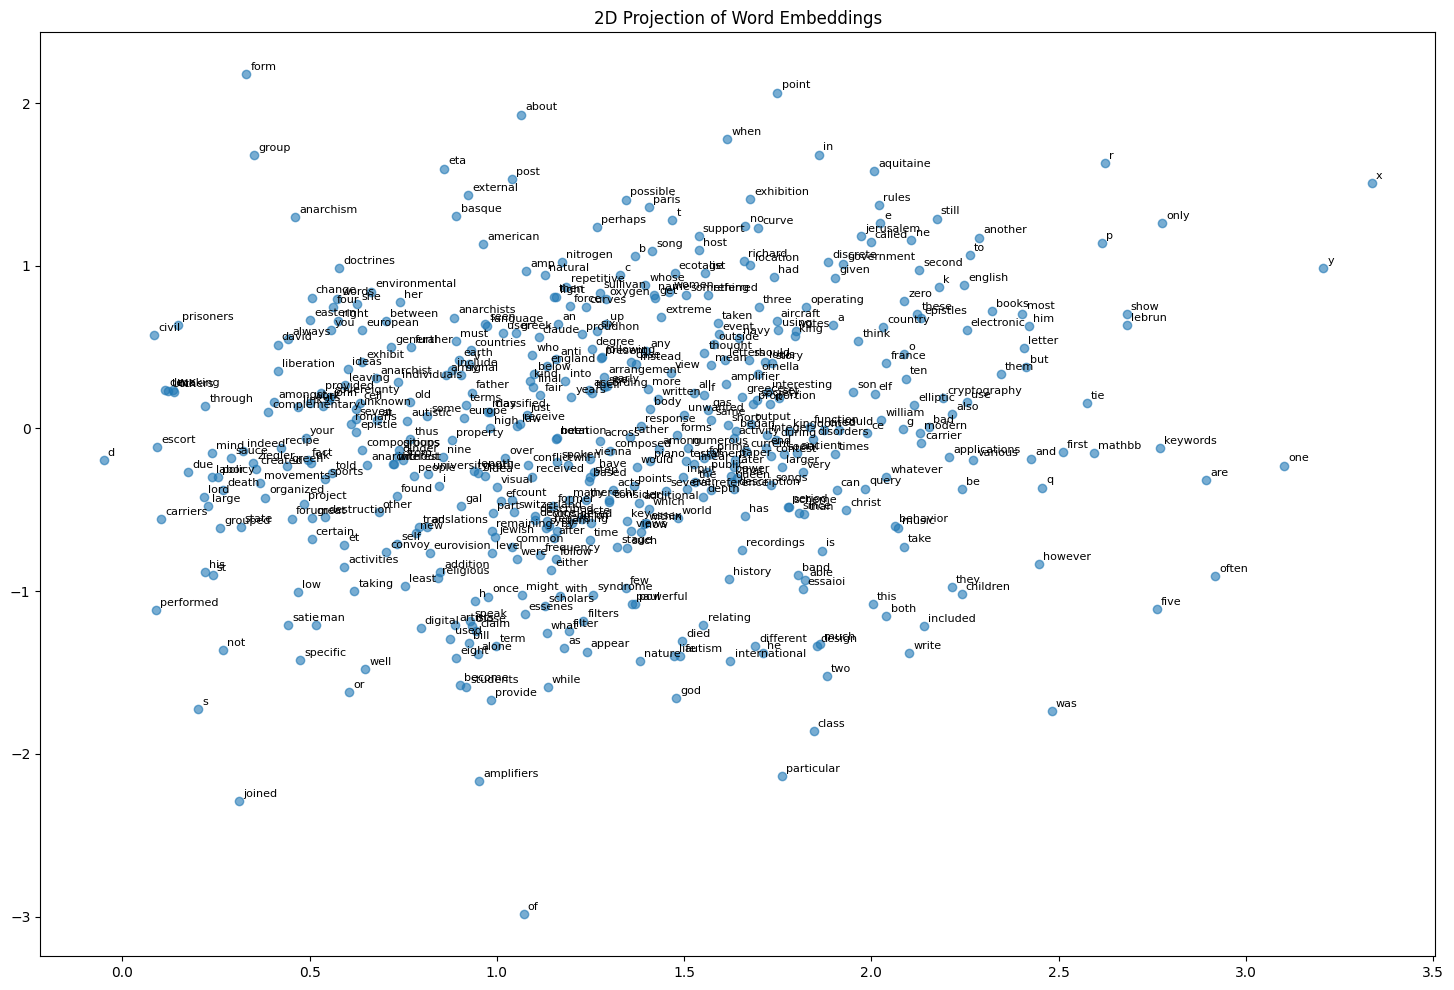


Testing with words found in vocabulary:

that - this + these => Expected 'those'
1. you (0.530) 
2. story (0.510) 
3. location (0.485) 
4. discrete (0.477) 
5. event (0.474) 

he - his + she => Expected 'her'
1. still (0.515) 
2. aircraft (0.485) 
3. change (0.479) 
4. disorders (0.473) 
5. votes (0.470) 
Missing words in vocabulary: woman. Skipping test.

Similar word analysis:

Words similar to 'a':
1. cryptography (0.528)
2. host (0.495)
3. leaving (0.494)
4. elliptic (0.484)
5. early (0.470)

Words similar to 'king':
1. him (0.556)
2. notation (0.535)
3. unwanted (0.503)
4. and (0.501)
5. groups (0.479)


In [ ]:
def evaluate_embeddings(WCe, vocab, word2idx, idx2word):
    """Evaluate embeddings through visualization and similarity analysis"""
    # 1. SVD Visualization
    plt.figure(figsize=(18, 12))
    
    # Select words avoiding UNK and rare terms
    plot_words = [w for w in vocab if w != '<UNK>' and word2idx[w] < len(WCe) and word2idx[w] < len(vocab)]
    
    # Get embeddings and reduce dimensionality
    embeddings = np.array([WCe[word2idx[w]] for w in plot_words])
    svd = TruncatedSVD(n_components=2)
    reduced_emb = svd.fit_transform(embeddings)
    
    # Plot with annotations
    plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], alpha=0.6)
    for i, word in enumerate(plot_words[:]):  # Label first 100
        plt.annotate(word, (reduced_emb[i, 0], reduced_emb[i, 1]), 
                     textcoords="offset points", xytext=(3,3), fontsize=8)
    plt.title("2D Projection of Word Embeddings")
    plt.show()

    # 2. Word Similarity Analysis
    def cosine_sim(a, b):
        return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    
    def analogy_test(w1, w2, w3, expected):
        # First check if all words exist in vocabulary
        missing_words = [w for w in [w1, w2, w3, expected] if w not in word2idx]
        if missing_words:
            print(f"Missing words in vocabulary: {', '.join(missing_words)}. Skipping test.")
            return
            
        vec = WCe[word2idx[w1]] - WCe[word2idx[w2]] + WCe[word2idx[w3]]
        similarities = []
        
        for idx, word in idx2word.items():
            if word not in [w1, w2, w3, '<UNK>'] and idx < len(WCe):
                similarities.append((word, cosine_sim(vec, WCe[idx])))
        
        top_matches = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
        
        print(f"\n{w1} - {w2} + {w3} => Expected '{expected}'")
        for i, (word, score) in enumerate(top_matches):
            print(f"{i+1}. {word} ({score:.3f}) {'**' if word == expected else ''}")

    # Test with words that exist in vocabulary
    print("\nTesting with words found in vocabulary:")
    existing_words = [w for w in vocab if w not in ['<UNK>']]
    
    analogy_test('that', 'this', 'these', 'those')
    analogy_test('he', 'his', 'she', 'her')
    analogy_test('king', 'man', 'woman', 'queen')
    
    # Show some similar words for common words that exist
    print("\nSimilar word analysis:")
    common_words = [w for w in ['a',"king"] if w in word2idx]
    for word in common_words[:3]:  # Just show first 3 to avoid too much output
        vec = WCe[word2idx[word]]
        similarities = []
        
        for idx, w in idx2word.items():
            if w != word and w != '<UNK>' and idx < len(WCe):
                similarities.append((w, cosine_sim(vec, WCe[idx])))
        
        top_matches = sorted(similarities, key=lambda x: x[1], reverse=True)[:5]
        print(f"\nWords similar to '{word}':")
        for i, (w, score) in enumerate(top_matches):
            print(f"{i+1}. {w} ({score:.3f})")

# Run evaluation
evaluate_embeddings(WCe, vocab, word2idx, idx2word)